In [2]:
import keras
from keras.optimizers import SGD, Adam, RMSprop
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, CuDNNGRU, CuDNNLSTM, \
    TimeDistributed, Reshape, Input, Dropout, RepeatVector, MaxPooling2D, \
    UpSampling2D, Cropping2D
from keras.activations import relu

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
T_pred = 16
T_in = 16
vid_l = T_in + T_pred
IMG_H = 125
IMG_W = 125
IMG_CH = 3

In [4]:
TD = TimeDistributed

inputs = Input(shape=(T_in, IMG_H, IMG_W, IMG_CH))

# Apply convolutions on the initial image input with increasing channel size.
conv_x = TD(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(inputs)
conv_x = TD(MaxPooling2D(pool_size=(2, 2)))(conv_x)
conv_x = TD(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(conv_x)
conv_x = TD(MaxPooling2D(pool_size=(2, 2)))(conv_x)
conv_x = TD(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu'))(conv_x)
print("Exit initial conv: ", conv_x.shape)

# We pass the flattened convolution output into a CuDNN-optimized LSTM.
# Outputs are disregarded for training but form the "encoded" representation.
enc_x = Reshape((T_in, -1))(conv_x)
encoded_output, hidden, cell = CuDNNLSTM(1024, return_state=True, return_sequences=False)(enc_x)

# Decode model output.
dec_raw_x = RepeatVector(T_pred)(encoded_output) # Input(shape=(None, 512,))
dec_x, _, _ = CuDNNLSTM(1024, return_state=True, return_sequences=True)(dec_raw_x, initial_state=[hidden, cell])
dec_x = TD(Reshape((8, 8, 16)))(dec_x)
print("Exit seq2seq: ", dec_x.shape)

# Upsample
dec_x = TD(Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)
dec_x = TD(Conv2D(64, kernel_size=(4, 4), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)
dec_x = TD(Conv2D(32, kernel_size=(4, 4), strides=(1,1), activation='relu'))(dec_x)
dec_x = TD(UpSampling2D(size=(3, 3)))(dec_x)
print(dec_x.shape)

predictions = TD(Conv2D(3, kernel_size=(2,2), strides=(1,1), activation='sigmoid'))(dec_x)
print("Final shape:", predictions.shape)


model = Model(inputs=inputs, outputs=predictions)

Exit initial conv:  (?, 16, 3, 3, 128)
Exit seq2seq:  (?, 16, 8, 8, 16)
(?, 16, 18, 18, 64)
(?, 16, 45, 45, 64)
(?, 16, 126, 126, 32)
Final shape: (?, 16, 125, 125, 3)


In [7]:
import h5py
import numpy as np
import random
from keras.utils import Sequence
import multiprocessing as mp

BATCH = 32
TOTAL_SIZE = 55424


def get_batch(i):
    with h5py.File('/home/ubuntu/bigstorage/dataset.h5', 'r') as f:
        X = np.array(f['X'][BATCH*i:BATCH*(i+1)], dtype=np.float32)
        np.divide(X, 255, out=X)
        Y = np.array(f['Y'][BATCH*i:BATCH*(i+1)], dtype=np.float32)
        np.divide(Y, 255, out=Y)
        p = np.random.permutation(BATCH)
        X_ = X[p]
        Y_ = Y[p]
        del(X)
        del(Y)
    return X_, Y_


class DataGen(Sequence):
    def __len__(self):
        return int(TOTAL_SIZE / BATCH)

    def __getitem__(self, idx):
        return get_batch(idx)

In [ ]:
# About 1 per second
model.compile(optimizer=RMSprop(0.002), loss='binary_crossentropy')
model.load_weights("model_weights_2.h5")
model.fit_generator(DataGen(), steps_per_epoch=TOTAL_SIZE/BATCH,
                    epochs=1, shuffle=True, use_multiprocessing=True,
                    workers=mp.cpu_count())
model.save_weights("model_weights_3.h5")
model.fit_generator(DataGen(), steps_per_epoch=TOTAL_SIZE/BATCH,
                    epochs=1, shuffle=True, use_multiprocessing=True,
                    workers=mp.cpu_count())
model.save_weights("model_weights_4.h5")
model.fit_generator(DataGen(), steps_per_epoch=TOTAL_SIZE/BATCH,
                    epochs=1, shuffle=True, use_multiprocessing=True,
                    workers=mp.cpu_count())
model.save_weights("model_weights_5.h5")
model.fit_generator(DataGen(), steps_per_epoch=TOTAL_SIZE/BATCH,
                    epochs=1, shuffle=True, use_multiprocessing=True,
                    workers=mp.cpu_count())
model.save_weights("model_weights_6.h5")

Epoch 1/1
  37/1732 [..............................] - ETA: 27:57 - loss: 0.4660

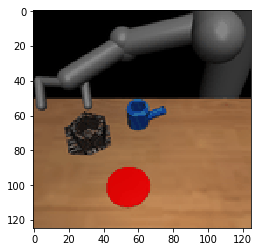

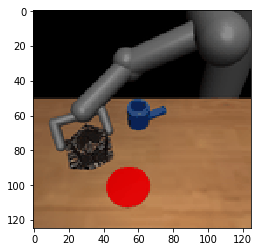

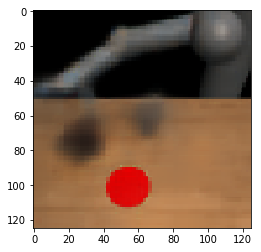

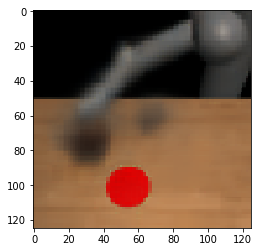

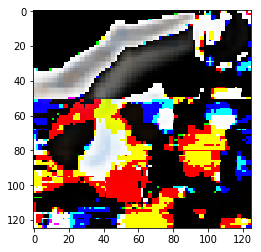

In [10]:
GAP = 25
model.load_weights("model_weights_5.h5")
with h5py.File('dataset.h5', 'r') as f:
    X = np.array(f['X'][-1 - GAP], dtype=np.float32)
    np.divide(X, 255, out=X)
    Y = np.array(f['Y'][-1 - GAP], dtype=np.float32)
    np.divide(Y, 255, out=Y)

import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.array(Y[0] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(Y[15] * 255, dtype=np.uint8))
plt.show()
preds = model.predict(np.array([X]))
plt.imshow(np.array(preds[0][0] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(preds[0][15] * 255, dtype=np.uint8))
plt.show()
plt.imshow(np.array(preds[0][15] * 255 - preds[0][0] * 255, dtype=np.uint8))
plt.show()

3x3 32-channel Conv2D
2x2 MaxPooling2D
3x3 64-channel Conv2D
2x2 MaxPooling2D
3x3 128-channel Conv2D

1024-hidden LSTM
1024-hidden LSTM

3x3 64-channel Conv2D
3x3 UpSampling
4x4 64-channel Conv2D
3x3 UpSampling
4x4 32-channel Conv2D
3x3 UpSampling
2x2 3-channel Conv2D

```
with h5py.File('/home/ubuntu/bigstorage/dataset.h5', 'r') as f:
    X = np.array(f['X'][:512], dtype=np.float32)
    np.divide(X, 255, out=X)
    Y = np.array(f['Y'][:512], dtype=np.float32)
    np.divide(Y, 255, out=Y)
    
# About 1 per second
model.load_weights("model_weights_2.h5")
model.fit(X, Y, batch_size=BATCH, epochs=3, shuffle=True)
```